## Cluster Technique Search and Accuracy Test

Adding in length it matters. Go back at into preprocessing and instead of taking the first value we need to group by and take the sum of each group instead. This is what causes the miss alignment in precursor statistics for the surge in that sequence. Could be affecting our clustering data. 

Checklist
- run with standard scaler instead
- add in implementation of bin scoring 
- check other cluster scoring methodologies instead of silhoutte 
- check other clustering options
- maybe do a grid search of each indivdual methodology instead 

No quantile standard scalar is much better

Cluster Profitability 1
- cluster and get cluster qaulity scores and then create  function that looks at the labels and finds the associated surge_target_scores and calculates the mean score for each cluster and from there finds the total difference in cluster averages. We want the clusters that have the greatest difference because that shows that each cluster is seperating by profitability

In [69]:
import pandas as pd
# from sklearn.cluster import KMeans
from sklearn.model_selection import GridSearchCV
import sklearn.metrics
import numpy as np
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
import datetime

#SPECIFIED CLUSTER DISCOVERY
# from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
# from sklearn.model_selection import GridSearchCV
# from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, SpectralClustering, Birch
from sklearn.cluster import KMeans, AgglomerativeClustering, SpectralClustering,\
MeanShift, AffinityPropagation, DBSCAN, OPTICS, Birch
from sklearn.metrics import silhouette_score

In [70]:
# BIN TECHNIQUE
# load pipeline 1 csv and prep for clustering
m2_pipeline = pd.read_csv('pipeline1.csv')
# change is surge price rate of change per observation, change.1 is precursor
# sum_change is surge sum_change per surge, and surge_area is surge alone

In [71]:
m2_pipeline.iloc[0,:]

group                                           2
time                              1660221654244.0
s_MP                                         30.0
change                                  -0.000533
type                                    precursor
p_MP                                        29.98
precursor_buy_cap_pct_change            -0.000044
precursor_ask_cap_pct_change            -0.000004
precursor_bid_vol_pct_change            -0.000017
precursor_ask_vol_pct_change            -0.000351
length                                          6
sum_change                               -0.00501
max_surge_mp                                 30.0
min_surge_mp                                 30.0
max_precursor_mp                            29.98
min_precursor_mp                            29.85
area                                    -0.030057
surge_targets_met_pct                   -0.066667
group.1                                         3
time.1                            1660221833233.0


In [72]:
keepable = ['precursor_buy_cap_pct_change', 
            'precursor_ask_cap_pct_change',
            'precursor_bid_vol_pct_change', 
            'precursor_ask_vol_pct_change',
            'sum_change',
            'length',
            'surge_targets_met_pct']
x = m2_pipeline[['surge_targets_met_pct']].values.astype(float)
m2_pipeline = m2_pipeline[keepable]

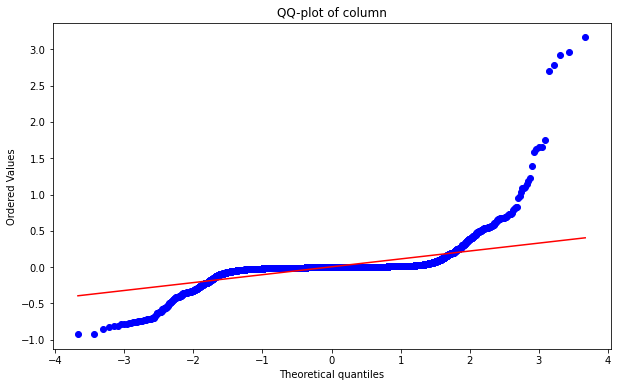

In [73]:
import scipy.stats as stats
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
stats.probplot(m2_pipeline['precursor_buy_cap_pct_change'], dist="norm", plot=plt)
plt.title('QQ-plot of column')
plt.show()


In [74]:
bins = [
    m2_pipeline['surge_targets_met_pct'].min() -1,  # Min value  # -4 to 0 divided into three equal parts
    -4/3,# Second bin edge for negative values
    -4/6,
    -4/12,
    0,
    0.125,
    0.25, 0.5, 0.75, 1,  # Four bins between 0 and 1
    2,  # One bin between 1 and 2
    m2_pipeline['surge_targets_met_pct'].max() + 1]
bin_labels = list(range(1, len(bins)))

In [75]:
for i in range(1, len(bins)):
    print(f'Bin {bin_labels[i-1]}: {bins[i-1]:.2f} - {bins[i]:.2f}')

Bin 1: -4.24 - -1.33
Bin 2: -1.33 - -0.67
Bin 3: -0.67 - -0.33
Bin 4: -0.33 - 0.00
Bin 5: 0.00 - 0.12
Bin 6: 0.12 - 0.25
Bin 7: 0.25 - 0.50
Bin 8: 0.50 - 0.75
Bin 9: 0.75 - 1.00
Bin 10: 1.00 - 2.00
Bin 11: 2.00 - 5.32


In [76]:
m2_pipeline['label'] = pd.cut(m2_pipeline['surge_targets_met_pct'], bins=bins, labels=bin_labels)

In [77]:
m2_pipeline.to_csv('binned_pipeline.csv')

### standardize all features pre train/test

In [78]:
print(m2_pipeline.isna().sum(axis=1).astype(bool).sum())

0


In [79]:
m2_pipeline = m2_pipeline.dropna()

# Splitting the dataframe into features and labels
X = m2_pipeline[['precursor_buy_cap_pct_change', 'precursor_ask_cap_pct_change','precursor_bid_vol_pct_change',
                'precursor_ask_vol_pct_change','sum_change', 'length']]
y = m2_pipeline[['surge_targets_met_pct','label']]

# Performing the test/train split and standardization
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


#from sklearn.preprocessing import QuantileTransformer
#qt = QuantileTransformer(output_distribution='normal', random_state=0)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
#X_train_scaled = pd.DataFrame(qt.fit_transform(X_train), columns=X_train.columns)
#X_test_scaled = pd.DataFrame(qt.transform(X_test), columns=X_test.columns)

In [80]:
def silhouette_scorer(estimator, X, y=None):
    labels = estimator.fit_predict(X)
    score = silhouette_score(X, labels)
    return score

In [81]:
clf = KMeans(n_clusters = 2)
clf.fit(X_train_scaled)
silhouette_scorer(clf, X_train_scaled, y=None)

0.8598523058552929

In [82]:
clf.labels_

array([0, 0, 0, ..., 0, 0, 0], dtype=int32)

In [83]:
y_train.surge_targets_met_pct.mean()

0.02128299758520008

In [84]:
def cluster_profitability(model, X, feature_name):
    """
    Compute the profitability score of the clustering model.
    
    Parameters:
    - model: Fitted clustering model
    - X: DataFrame, the original data with all features
    - feature_name: str, the name of the feature to compute profitability
    
    Returns:
    - score: float, computed profitability score
    """
    labels = model.labels_
    df = pd.concat([X.reset_index(drop=True), pd.Series(labels, name='Cluster_Label')], axis=1)
    cluster_means = df.groupby('Cluster_Label')[feature_name].mean()
    
    # Custom scoring logic here. 
    score = cluster_means.std()  # Standard deviation between cluster means
    
    return score


In [85]:
cluster_profitability(clf, y_train, 'surge_targets_met_pct')

0.0569272820887997

In [86]:
# Define a range for n_clusters
n_clusters_options = [2, 3, 4, 5, 6, 7, 8, 9, 10]

# Define your models
clustering_models = [
    ('KMeans', KMeans()),
    ('Birch', Birch()),
    ('Hierarchical', AgglomerativeClustering())
]

results_df = pd.DataFrame(columns=['algo', 'n_clusters', 'score', 'profit'])

# Loop over the models
for model_name, model in clustering_models:
    # Loop over the n_clusters options
    for n_clusters in n_clusters_options:
        # Set the number of clusters and fit the model
        model.set_params(n_clusters=n_clusters)
        labels = model.fit_predict(X_train_scaled)

        # Evaluate using the silhouette score
        score = silhouette_score(X_train_scaled, labels)
        # Compute profitability score
        profit = cluster_profitability(model, y_train, 'surge_targets_met_pct')

        # Store the best parameters, model, and score
        print(f'{model_name} with {n_clusters} clusters:')
        print(f'Silhouette score: {score:.4f}')
        print(f'Profitability score: {profit:.4f}\n')

        
        results_df = results_df.append({
            'algo': model_name, 
            'n_clusters': n_clusters, 
            'score': score,
            'profit': profit
        }, ignore_index=True)
        
 

KMeans with 2 clusters:
Silhouette score: 0.8889
Profitability score: 0.0346

KMeans with 3 clusters:
Silhouette score: 0.8121
Profitability score: 0.0299

KMeans with 4 clusters:
Silhouette score: 0.8131
Profitability score: 0.1545

KMeans with 5 clusters:
Silhouette score: 0.5268
Profitability score: 0.1294

KMeans with 6 clusters:
Silhouette score: 0.5334
Profitability score: 0.1372

KMeans with 7 clusters:
Silhouette score: 0.5112
Profitability score: 0.2041

KMeans with 8 clusters:
Silhouette score: 0.5642
Profitability score: 0.1139

KMeans with 9 clusters:
Silhouette score: 0.5258
Profitability score: 0.1878

KMeans with 10 clusters:
Silhouette score: 0.5002
Profitability score: 0.1781

Birch with 2 clusters:
Silhouette score: 0.8696
Profitability score: 0.0090

Birch with 3 clusters:
Silhouette score: 0.8507
Profitability score: 0.1525

Birch with 4 clusters:
Silhouette score: 0.7583
Profitability score: 0.1313

Birch with 5 clusters:
Silhouette score: 0.7652
Profitability scor

In [87]:
clustering_models = [
    ('Meanshift',  MeanShift( bandwidth=None, seeds=None, bin_seeding=False, min_bin_freq=1, cluster_all=True, n_jobs=None, max_iter=300)),
    ('AffinityPropagation', AffinityPropagation( damping=0.5, max_iter=200, convergence_iter=15, copy=True, preference=None, affinity='euclidean', verbose=False, random_state=42)),
    ('DBSCAN', DBSCAN(eps=0.5, min_samples=5, metric='euclidean', metric_params=None, algorithm='auto', leaf_size=30, p=None, n_jobs=None)),
    ('OPTICS', OPTICS( min_samples=5, max_eps=3, metric='minkowski', p=2, metric_params=None, cluster_method='xi', eps=None, xi=0.05, predecessor_correction=True, min_cluster_size=None, algorithm='auto', leaf_size=30, n_jobs=None))]

In [88]:

# Loop over the models
for model_name, model in clustering_models:

    labels = model.fit_predict(X_train_scaled)
    n_clusters_ = len(set(labels)
    # Evaluate using the silhouette score
    if n_clusters_ > 1:
        # Evaluate using the silhouette score
        score = silhouette_score(X_train_scaled, labels)
        profit = cluster_profitability(model, y_train, 'surge_targets_met_pct')
    else:
        score = None  # or another indicator value, or you might log/print a message and continue
    # Compute profitability score
        profit =  None 
    # Store the best parameters, model, and score
    print(f'{model_name} with {n_clusters} clusters:')
    if n_clusters_ > 1:
        print(f'Silhouette score: {score:.4f}')
        print(f'Profitability score: {profit:.4f}\n')


    results_df = results_df.append({
        'algo': model_name, 
        'n_clusters': n_clusters, 
        'score': score,
        'profit': profit
    }, ignore_index=True)
        
 

Meanshift with 10 clusters:
Silhouette score: 0.4776
Profitability score: 0.4228

AffinityPropagation with 10 clusters:
DBSCAN with 10 clusters:
Silhouette score: 0.4413
Profitability score: 0.0989

OPTICS with 10 clusters:
Silhouette score: -0.5760
Profitability score: 0.1114



In [104]:
sorted_df = results_df.sort_values(by='profit', ascending=False)
sorted_df

,algo,n_clusters,score,profit
27,Meanshift,10,0.477647,0.422803
14,Birch,7,0.73976,0.217987
16,Birch,9,0.563139,0.207827
5,KMeans,7,0.511235,0.204077
15,Birch,8,0.562683,0.20353
17,Birch,10,0.563539,0.201124
25,Hierarchical,9,0.460035,0.19559
7,KMeans,9,0.52576,0.187796
26,Hierarchical,10,0.457981,0.185215
8,KMeans,10,0.500212,0.178062


In [113]:
clf = Birch(n_clusters = 7)
labels = clf.fit_predict(X_train_scaled)


In [114]:
len(set(labels)) - (1 if -1 in labels else 0)

7

In [115]:
df = pd.concat([y_train.reset_index(drop=True), pd.Series(labels, name='Cluster_Label')], axis=1)
cluster_means = df.groupby('Cluster_Label')['surge_targets_met_pct'].mean()
    
# Custom scoring logic here. 
score = cluster_means.std()  # Standard deviation between cluster means
    

In [116]:
cluster_means

Cluster_Label
0    0.020329
1   -0.038373
2    0.064452
3   -0.137443
4    0.086935
5    0.218863
6   -0.462012
Name: surge_targets_met_pct, dtype: float64

In [117]:
df[df['Cluster_Label'] == 5]['label'].value_counts()

7     12
4      6
3      5
6      5
10     3
5      2
8      2
9      1
1      0
2      0
11     0
Name: label, dtype: int64

In [ ]:
# chose model to precede with and use the cluster labels as output into csv.

#### BELOW THIS LINE DEPPRECIATED FOR NOW

## explore top results by cluster quality scoring

use silhouette viz

then davies

then kolmogorov

In [ ]:
#charting silhouettes
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import silhouette_samples, silhouette_score

# Calculate the silhouette scores for each sample
silhouette_values = silhouette_samples(X, labels)

# Calculate the average silhouette score
average_score = silhouette_score(X, labels)

# Plot the silhouette chart
fig, ax = plt.subplots()
y_lower = 10

for i in range(n_clusters):
    # Aggregate the silhouette scores for samples in cluster i and sort them
    ith_cluster_silhouette_values = silhouette_values[labels == i]
    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    # Fill the silhouette chart with the corresponding color
    color = cm.nipy_spectral(float(i) / n_clusters)
    ax.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, facecolor=color, edgecolor=color, alpha=0.7)

    # Label each cluster with its silhouette score
    ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
    
    # Compute the new y_lower for next plot
    y_lower = y_upper + 10

ax.set_xlabel("Silhouette coefficient values")
ax.set_ylabel("Cluster label")

# The vertical line indicates the average silhouette score
ax.axvline(x=average_score, color="red", linestyle="--")

plt.show()


## top method hyperparameter optimization
take the top technique by silhouette then dive into a fuller exploration of its specific hyperparameters

In [ ]:
from sklearn.cluster import SpectralClustering
from sklearn.model_selection import RandomizedSearchCV

param_distributions = {
    'n_clusters': [2, 3, 4],
    'affinity': ['nearest_neighbors', 'rbf'],
    'gamma': [0.1, 1.0, 10.0]
}

clustering = SpectralClustering()
random_search = RandomizedSearchCV(clustering, param_distributions)
random_search.fit(X)


## estimate the model accuracy, givne best hyperparameters

In [ ]:
#use best model:
from sklearn.model_selection import train_test_split
from sklearn.cluster import SpectralClustering
from sklearn.metrics import accuracy_score
X = m2_pipeline.drop(columns=['bin'])
y = m2_pipeline['bin']
# Splitting the dataset into train and test sets

#USE STANDARD SCALING ONCE YOU DIVDE TEST AND TRAIN NOT BEFORE
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Creating an instance of SpectralClustering
model = SpectralClustering(n_clusters=7)

# Fitting the model to the training data
model.fit_predict(X_train)

# Predicting labels for the testing data
y_pred = model.predict(X_test)

# Calculating the accuracy score
accuracy = accuracy_score(y_test, y_pred)


In [ ]:
def silhouette_scorer(estimator, X, y=None):
    labels = estimator.fit_predict(X)
    score = silhouette_score(X, labels)
    return score
# Defining the parameter grid for GridSearchCV
param_grid = {'n_clusters': [2,3,4,5,6,7,8,9,10]}  #'algorithm': ['auto', 'full', 'elkan']

clustering_models = [
    ('KMeans', KMeans()),
    ('Birch', Birch()),
    ('Hierarchical',AgglomerativeClustering())]
# Performing GridSearchCV for each clustering model
for model_name, model in clustering_models:
    grid_search = GridSearchCV(model, param_grid, scoring=silhouette_scorer)
    grid_search.fit(X_train_scaled)
    # Evaluating the best model based on silhouette score
    best_model = grid_search.best_estimator_
    best_score = grid_search.best_score_
    print(f'{model_name}:')
    print(f'Best parameters: {grid_search.best_params_}')
    print(f'Silhouette score (train): {best_score:.4f}')
    best_params = grid_search.best_params_
    pkg = {"algo": model_name, "best_params": grid_search.best_params_,
        "best_estimator": grid_search.best_estimator_,
        "best_score": best_score} 
    # # Add the cluster label as a new column
    #method_df = X_train_scaled
    #method_df['label'] = y_train
    #method_df['cluster_label'] = best_model.labels_

    #now = datetime.datetime.now()
    #print("Current date and time: ")
    #print(now.strftime("%Y-%m-%d %H:%M:%S"))
    #run_time = now.strftime("%Y-%m-%d %H:%M:%S")
    #file_name = 'clustered/'+ 'clustered_'+ model_name+' _'+ run_time+ '.csv'
    #print(file_name)
    #method_df.to_csv(file_name)
    # print(pkg)
    global_test_results.append(pkg)
 